# Save a copy in your Google Drive with your initials appended to the filename
Do this first, then proceed.

# Lab 6: Escape response kinematics

In this lab you will be working with fish escape response data collected from videos of experiments conducted by Prof. Alberto Soto and colleagues Jenn Bullard and Dr. Katie Whitlow at Friday Harbor Labs (part of University of Washington). The fish used in this experiment is the [Pacific staghorn sculpin](https://mexican-fish.com/pacific-staghorn-sculpin/). To induce a fast-start escape response, we dropped an object into the experimental tank. This produces an acoustic and mechanical stimulus to the escape response circuit.  

To gather these data, we tracked the position of the sculpin's mouth and center-of-mass. The data sets contain the following variables: 

`time, xMouth, yMouth, xCOM, yCOM`  

## Useful parameters and notes

* The units of position are given in centimeters, time is in seconds.
* The videos were recorded at 500fps, so the $\Delta t$ between consecutive frames is 0.002 seconds (2 ms). 
* The timeseries data begin a couple of frames before the start of the escape response.
* At the top of the CSV file, there are 3 relevant video parameters: **start stimulus, start tracking, start escape**, given as frame numbers. You will use this information to caluclate the response latency, which is the time between the stimulus start and the start of the escape response. 

* Conversion factor with units cm/pixels:
`cm_px = 4.5285e-2`

* Video dimensions in pixels:
  * `vid_width = 1920`
  *`vid_height = 1080`

* The origin for these data is set to center of the image frame. We'll want to redefine a new origin to be the bottom left corner of the image. 
To do this use the following equations: 
  * `x_new = cm_px*(1920/2) + x`
  * `y_new =cm_px*(1080/2) + y`

* Position where the stimulus hits the water (cm), relative to the new origin:
  * `stimX = cm_px*(1920/2) + 29.680`
  * `stimY = cm_px*(1080/2) + (-15.9750)`


# Lab 6: Tasks
In this lab you will work with 2 different escape response sequences, they may be found in your Drive folder. 

For each sequence:
  * Determine the total duration in **sec** of each sequence
  * Calculate the response latency, units should be reported in **ms**
  * Plot the trajectory of the fish's center-of-mass, make sure to denote the initial position of the fish on the figure
  * Calculate the distance in **cm** between the stimulus position and the initial position of the fish.
  * Compute and plot the following derived kinematic variables with appropriate units 
    * Heading of fish, 
$\theta (t)$,
computed using the vector from (xCOM, yCOM) to (xMouth, yMouth)
    * Velocity, 
$\dot x(t) = v(t)$
    * Acceleration, 
$\dot v(t) = a(t)$
    * Rotational velocity, 
$\dot \theta(t)$
  * Use the heading and rotational velocity data to calculate the timing (**ms** after escape begins) and duration (in **ms**) of Stage 1, Stage 2, and Stage 3 of the escape response. 
  * Determine whether the escape was toward the stimulus or away from the stimulus

**Note:** Derivatives should be computed using the finite difference method provided

## What to turn in
In contrast to previous labs, rather than submitting a pdf of your Google Colab notebook, you’ll compile the results of your lab work (the tasks listed above) into a separate file. 

# Load the Dependencies and Data

In [ ]:
import scipy.io
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

%matplotlib inline

# Scipy signal for smoothing noisy data
from scipy import signal

# Plotly for interactive plots
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

### Sample code to load the timeseries and video parameter data separately 

In [ ]:
# sample data URL
sample_url = "https://raw.githubusercontent.com/adsoto/Shark-Analysis/main/180815-expF-trial2.csv"

In [ ]:
# Read timeseries data 
escape_1 = pd.read_csv(sample_url, skiprows=3)
escape_1.head()

,time,xMouth,yMouth,xCOM,yCOM
0,1.294,24.740876,-3.865762,20.16185,-4.579476
1,1.296,24.649917,-3.956721,20.16185,-4.579476
2,1.298,24.695396,-3.729323,20.16185,-4.579476
3,1.300,24.740876,-3.774803,20.16185,-4.579476
4,1.302,24.695396,-3.956721,20.16185,-4.498423


In [ ]:
# video parameter rows
param_rows = [0, 1]

# Read video parameters 
escape_1_params = pd.read_csv(sample_url, 
                              skiprows = lambda x: x not in param_rows, 
                              usecols=['start stimulus', 'start tracking', 'start escape'])

escape_1_params

,start stimulus,start tracking,start escape
0,13,647,648


## Numerical differentiation: Finite differences
Use the following function to compute the derivative of a 1D array versus time. 

Thanks to Martin Susanto for writing the function and test case. 

In [ ]:
def finite_difference(t, x):
    '''
    Computes the derivative using finite difference approximation.

    Inputs:
        t (1D array)
        x (1D array)

    Returns:
        v (1D array): derivative of x with respect to t
    '''

    lx = len(x)
    v = []

    # Check for equal length
    if x.shape[0] != t.shape[0]:
        raise ValueError('x and t must have the same first dimension')
    
    if lx == 1:
        return 0

    # forward difference for 1st element
    v += [(x[1]-x[0])/(t[1]-t[0])]

    # central difference for central elements
    for i in range(lx-1)[1:]:
        v += [(x[i-1]-x[i+1])/(t[i-1]-t[i+1])]

    # backward difference for last element
    v += [(x[-1]-x[-2])/(t[-1]-t[-2])]

    return v

### Sample call to the finite_difference function

The code below computes the derivate of $\cos(t)$ and plots the result over the exact solution. 

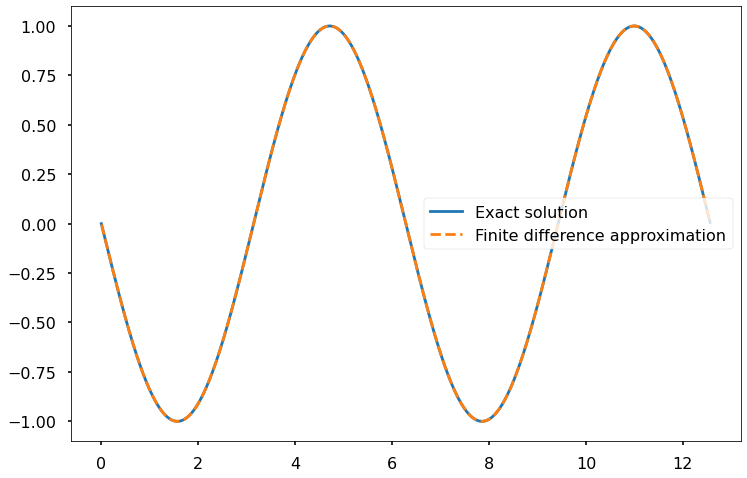

max absolute error: 0.004999958333473664


In [ ]:
    plt.style.use('seaborn-poster')

    # step size for time interval
    h = 0.01

    # define 1D time array
    t = np.arange(0, 4*np.pi, h) 

    # generate a 1D array for cos(t)
    x = np.cos(t) 

    # compute the derivative of x w.r.t. time
    dot_x = finite_difference(t, x)

    # exact solution; -sin(t)
    exact_solution = -np.sin(t)
    
    # Plot the results
    plt.figure(figsize = (12, 8))
    plt.plot(t, exact_solution, \
            label = 'Exact solution')
    plt.plot(t, dot_x, '--', \
            label = 'Finite difference approximation')
    plt.legend()
    plt.show(block=True)

    # Compute max error between 
    # numerical derivative and exact solution
    max_error = max(abs(exact_solution - dot_x))
    print("max absolute error:", max_error)